#### Lifespan normative modeling for functional connectome
This demo shows a tutorial to establish connectome-based normative models using the generalized additive model for location, scale, and shape (GAMLSS). Taking global system segregation as an example, we used the samples from all healthy populations (N = 33,250) to describe the normative growth patterns of this metric.

To run this tutorial, you need an R environment. Here, we install the `rpy2` package to enable seamless interaction between Python and R:

In [1]:
# pip3 install rpy2==3.5.12

In [3]:
# Load the rpy2 extension to enable seamless integration and interaction between Python and R
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
%%R
## Use the rpy2 magic command to run R code within a Python environment
## Install the 'gamlss' package in the R environment
install.packages('gamlss')

NULL


In [ ]:
%%R
# load the 'gamlss' package in the R environment
library(gamlss)

##### Load Data


In [7]:
%%R

M_HC <- read.csv("data.csv")
Phenotype_name <- "global system segregation"

head(M_HC)

  X SubID    Age Sex SiteID meanFD phenotype
1 1  Sub1 10.917   0  Site6  0.143 0.7174894
2 2  Sub2  9.333   1  Site7  0.211 0.6560794
3 3  Sub3 10.333   1 Site12  0.079 0.7055883
4 4  Sub4  9.167   1 Site17  0.148 0.6790252
5 5  Sub5  9.083   1  Site3  0.077 0.7314070
6 6  Sub6  9.833   0 Site17  0.093 0.6999744


##### Step 1: Select the best data distributions
While the World Health Organization provides guidelines for modeling anthropometric growth charts (such as head circumference, height, and weight) using the Box‒Cox t-distribution as a starting point, we recognized that the growth curves of brain neuroimaging metrics do not necessarily follow the same underlying distributions. Therefore, we evaluated all continuous distribution families (n=51) for model fitting. To identify the optimal distribution, we fitted GAMLSS with different distributions to four representative global functional metrics (global mean of functional connectome, global variance of functional connectome, global atlas similarity, and global system segregation) and assessed model convergence. We used the Bayesian information criterion (BIC) to compare model fits among the converged models, with a lower BIC indicating a better fit. The `Johnson’s Su (JSU) distribution` consistently provided the best fit across all the evaluated models. 

##### Step 2: GAMLSS model details
We performed the GAMLSS procedure with the global system segregation as the dependent variable, age as a smoothing term (using the B-spline basis function), sex and in-scanner head motion (mean frame displacement) as other fixed effects, and scanner sites as random effects. We fitted three GAMLSS models with different degrees of freedom (df = 3-5) for the B-spline basis functions in the location (𝜇) parameters, and set default degrees of freedom (df = 3) for the B-spline basis functions in the scale (𝜎) parameters.

Due to the lengthy runtime, we have provided the precomputed model (Model_global system segregation.RData). You can skip to Step 6, load the model, and proceed with the subsequent analysis.

In [ ]:
%%R

Phenotype_name <- "global system segregation"

con<-gamlss.control(n.cyc=200)

mod1<-gamlss(phenotype~bs(Age,df=3) + Sex + meanFD + random(as.factor(SiteID)),
             sigma.fo=~bs(Age) + Sex,
             nu.fo=~1,
             nu.tau=~1,
             family=JSU,
             data=M_HC,
             control=con)
mod2<-gamlss(phenotype~bs(Age,df=4) + Sex + meanFD + random(as.factor(SiteID)),
             sigma.fo=~bs(Age) + Sex,
             nu.fo=~1,
             nu.tau=~1,
             family=JSU,
             data=M_HC,
             control=con)
mod3<-gamlss(phenotype~bs(Age,df=5) + Sex + meanFD + random(as.factor(SiteID)),
             sigma.fo=~bs(Age) + Sex,
             nu.fo=~1,
             nu.tau=~1,
             family=JSU,
             data=M_HC,
             control=con)


##### Step 3: Select the best model

In [9]:
%%R

conv<-matrix(data=0,nrow=1,ncol=3)
for (i in 1:3) {
  command <- paste0( "conv[1, i] <- mod", as.character(i), "$converged" )
  eval(parse(text = command))
}
bic_val<-matrix(data=0,nrow=1,ncol=3)
for (i in 1:3) {
  command <- paste0( "bic_val[1, i] <- mod", as.character(i), "$sbc" )
  eval(parse(text = command))
}

fit_best_order <- as.character(which.min(bic_val))
fit_best_order

[1] "2"


In [10]:
%%R
conv

     [,1] [,2] [,3]
[1,]    1    1    1


In [11]:
%%R
bic_val

          [,1]      [,2]      [,3]
[1,] -131139.1 -131196.4 -131165.7


##### Step 4: Plot normative centiles
Using the `getQuantile` function, we obtained normative centiles for each site and sex. By averaging these centiles across all sites and across male and female, we derived the overall lifespan growth curves for the population.

In [ ]:
%%R

quantiles<-c(0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99)
site_unique<-as.character( unique(M_HC$SiteID) )
n_sites <- length(site_unique)
n_quantiles <- length(quantiles)
n_points <- 8021
Centiles_male <- array(NA, dim = c(n_sites, n_quantiles, n_points))
Centiles_female <- array(NA, dim = c(n_sites, n_quantiles, n_points))
x_female <- seq(-0.2, 80, length.out = 8021)
x_male <- seq(-0.2, 80, length.out = 8021)

for (idx_site in 1:length(site_unique)){
  print(idx_site)
  for (i in 1:length(quantiles)){
    command <- paste0("Qua <- getQuantile(mod", fit_best_order ,", quantile=quantiles[i],term='Age',fixed.at=list(Sex=0, SiteID=site_unique[idx_site]), n.points = 8020)")
    eval(parse(text = command))
    Centiles_female[idx_site, i, ] <- Qua(x_female)

    command <- paste0("Qua <- getQuantile(mod", fit_best_order ,", quantile=quantiles[i],term='Age',fixed.at=list(Sex=1, SiteID=site_unique[idx_site]), n.points = 8020)")
    eval(parse(text = command))
    Centiles_male[idx_site, i, ] <- Qua(x_male)
  }
}

new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 


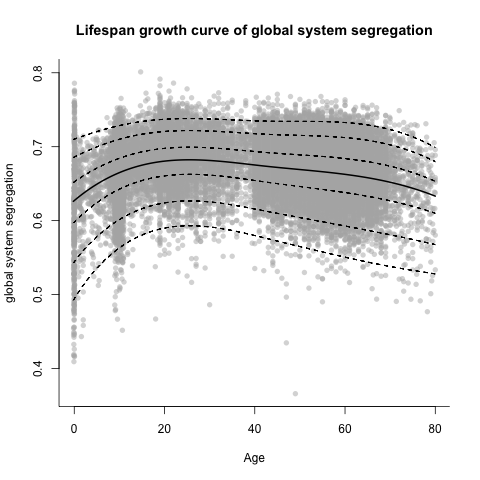

In [14]:
%%R
################################################################################ plot centiles
Centiles_female <- apply(Centiles_female, c(2, 3), mean)
Centiles_male <- apply(Centiles_male, c(2, 3), mean)
Centiles <- (Centiles_female + Centiles_male) / 2

command <- paste0( "best_model <- mod", fit_best_order)
eval(parse(text = command))
# step : get fitted data for only Age Iterm
Term_contri <- predict(best_model, what = c("mu", "sigma", "nu", "tau"), newdata = M_HC, type="term")
Age_Term <- M_HC$phenotype - Term_contri[,4] - Term_contri[,3] - Term_contri[,2]
plot(M_HC$Age, Age_Term,
     col = rgb(0.7, 0.7, 0.7, 0.5), 
     pch = 16,
     xlab = "Age",
     ylab = Phenotype_name,
     bty = "l",
     main = paste0("Lifespan growth curve of ", Phenotype_name))
X <- seq(-0.2, 80, length.out = 8021)
for (i in 1:7) {
  if (i == 4) {
    lines(X, Centiles[i, ], col = "black", lwd = 2, lty = 1)
  } else {
    lines(X, Centiles[i, ], col = "black", lwd = 1, lty = 2)
  }
}

##### Step 5: Save the model

In [15]:
%%R
################################################################################ Step 5: Save model and Data
save(best_model, file = paste0("Model_", Phenotype_name ,".RData")) # save model

##### Step 6: Load the precomputed model and plot centiles

In [16]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
%%R
library(gamlss)
M_HC <- read.csv("data.csv")
Phenotype_name <- "global system segregation"
load(paste0("Model_", Phenotype_name ,".RData")) 

In [18]:
%%R
best_model


Family:  c("JSU", "Johnson SU") 
Fitting method: RS() 

Call:  gamlss(formula = phenotype ~ bs(Age, df = 4) + Sex +  
    meanFD + random(as.factor(SiteID)), sigma.formula = ~bs(Age) +  
    Sex, nu.formula = ~1, family = JSU, data = M_HC,  
    control = con, nu.tau = ~1) 

Mu Coefficients:
              (Intercept)           bs(Age, df = 4)1  
                 0.648723                   0.076404  
         bs(Age, df = 4)2           bs(Age, df = 4)3  
                 0.042201                   0.037238  
         bs(Age, df = 4)4                        Sex  
                 0.007399                  -0.003552  
                   meanFD  random(as.factor(SiteID))  
                -0.098315                         NA  
Sigma Coefficients:
(Intercept)     bs(Age)1     bs(Age)2     bs(Age)3          Sex  
   -3.12263     -0.96025      0.14041     -0.24015      0.01581  
Nu Coefficients:
(Intercept)  
     -1.373  
Tau Coefficients:
(Intercept)  
     0.8812  

 Degrees of Freedom fo

new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New w

此外: There were 28 warnings (use warnings() to see them)


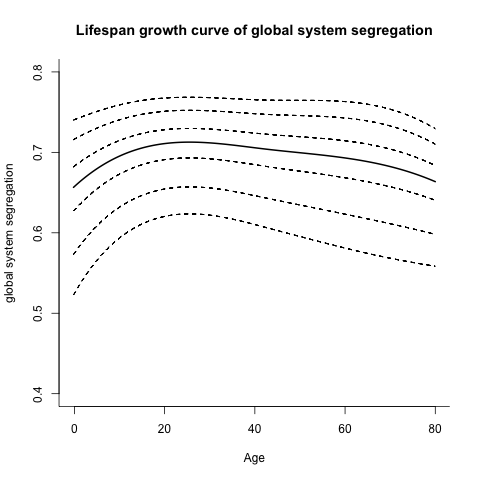

In [20]:
%%R
################################################################################ Step 3: Get centiles
quantiles<-c(0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99)
n_quantiles <- length(quantiles)
n_points <- 8021
Centiles_male <- array(NA, dim = c(n_quantiles, n_points))
Centiles_female <- array(NA, dim = c(n_quantiles, n_points))
x_female <- seq(-0.2, 80, length.out = 8021)
x_male <- seq(-0.2, 80, length.out = 8021)

for (i in 1:length(quantiles)){
    Qua <- getQuantile(best_model, quantile=quantiles[i],term='Age',fixed.at=list(Sex=0, SiteID="Site1"), n.points = 8020)
    Centiles_female[i,] <- Qua(x_female)

    Qua <- getQuantile(best_model, quantile=quantiles[i],term='Age',fixed.at=list(Sex=1, SiteID="Site1"), n.points = 8020)
    Centiles_male[i,] <- Qua(x_male)
}

################################################################################ Step 4: Plot centiles for Site1
Centiles <- (Centiles_female + Centiles_male) / 2
plot(X, Centiles[1, ], 
     type = "n", 
     xlab = "Age", 
     ylab = Phenotype_name, 
     bty = "l",
     ylim = c(0.4, 0.8),
     main = paste0("Lifespan growth curve of ", Phenotype_name))

X <- seq(-0.2, 80, length.out = 8021)
for (i in 1:7) {
  if (i == 4) {
    lines(X, Centiles[i, ], col = "black", lwd = 2, lty = 1)
  } else {
    lines(X, Centiles[i, ], col = "black", lwd = 1, lty = 2)
  }
}